## Project 2: GWAS (genomics)

The goal for this project is to do a genome-wide association study (GWAS) using a mock dataset (since the real datasets required for this typically aren't publicly available).


DISCLAIMER: the purpose of this analysis is to be educational and simplistic, not to follow current best-practices for GWAS. If you're doing this for real as part of a research project, you should probably use one of the standard GWAS software tools like [PLINK](https://www.cog-genomics.org/plink/2.0/).


In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
# random seed for reproducibility
np.random.seed(42)

### Step 1: Logistic Regression Review (OPTIONAL)

To check for a relationship between each SNP and the zombie phenotype, we'll use a logistic regression test. If you want to get a better idea of how this test works, check out this [great video series from Statquest](https://www.youtube.com/playlist?list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe). However, even though it's good to understand how this test works, it's not really necessary for the purposes of this class, so this section is optional.

**The important thing is that it will give us a p-value for each SNP. Remember, a p-value tells us the probability of seeing a result (in this case, a relationship between SNP genotype and zombie phenotype) as extreme as the one we're seeing, by coincidence alone if nothing interesting is going on (called the null hypothesis -- in this case, that there is no true relationship between a SNP genotype and zombie phenotype). The lower the p-value, the more of a coincidence would be required to see the results we're seeing, under the assumption that the null hypothesis is true.**

So that's the important part. It's good to know the details about how the test works, but if you find it confusing or don't understand some parts, don't worry!

Anyway, before we get to the zombie dataset, we'll make up some example data for a single SNP to practice doing the logistic regression test.

In [3]:
# making test data one SNP
N = 200

p_control = 0.2
p_case = 0.8

snp_control = np.random.choice([0,1,2], size=int(N/2), p = [(1-p_control)**2, 2*p_control*(1-p_control), p_control**2])
snp_case = np.random.choice([0,1,2], size=int(N/2), p=[(1-p_case )**2, 2*p_case *(1-p_case ), p_case**2])

# combine
snp = np.concatenate([snp_control, snp_case])
labels = np.array([0]*100 + [1] * 100)

In [4]:
print("Genotype shape:", snp.shape)
print("First couple genotypes:", snp[0:10])
print("Unique genotype values:", np.unique(snp))
print()
print("Labels shape:", labels.shape)
print("First couple lables:", labels[0:10])
print("Unique lable values:", np.unique(labels))

Genotype shape: (200,)
First couple genotypes: [0 1 1 0 0 0 0 1 0 1]
Unique genotype values: [0 1 2]

Labels shape: (200,)
First couple lables: [0 0 0 0 0 0 0 0 0 0]
Unique lable values: [0 1]


Next, we'll plot the data to visualize it.

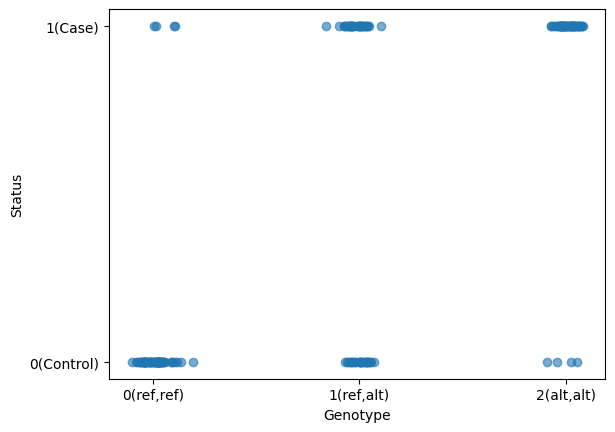

In [5]:
plt.figure()

# add small random noise for display
x_jitter = snp + np.random.normal(0, 0.05, size = N)
plt.scatter(x_jitter, labels, alpha=0.6)
plt.yticks([0,1], ["0(Control)", "1(Case)"])
plt.xticks([0,1,2], ["0(ref,ref)", "1(ref,alt)", "2(alt,alt)"])

plt.xlabel("Genotype")
plt.ylabel("Status")
plt.show()

The goal of logistic regression is to fit this equation to the data:

$$
{\huge p(x) = \dfrac{1}{1+e^{-(\beta_0+\beta_1 x)}}}
$$

**$x \in (0,1,2)$ :** the genotype of a given sample for a specific SNP. Could be 0 (ref,ref), 1 (ref,alt), or 2 (alt,alt).

**$p(x)$ :** the predicted probability that a sample is a zombie, given what we know about it's genotype ($x$) for a particular SNP.

**$\beta_0$ :** a model parameter we'll fit to the data that is related to the baseline probability that a sample is a zombie, when a person has genotype $x=0$ (which nullifies the $\beta_1$ term in the equation). A value of $\beta_0 = 0$ corresponds to a baseline probability of 0.5 that a sample with genotype $x=0$ is a zombie: $p(0) =  \frac{1}{1+e^{-(\beta_0 + \beta_1 x)}} = \frac{1}{1+e^{-(0 + \beta_1 0)}} = \frac{1}{1+e^{0}} = \frac{1}{1+1} = \frac{1}{2} = 0.5$. A value of $\beta_0$ other than 0 corresponds to a baseline probability of something other than 0.5 that a sample with a genotype of $x=0$ is a zombie.

**$\beta_1$ :** a model parameter we'll fit to the data that is related to how the probability that a sample is a zombie changes from the baseline if the person has genotype $x=1$ or $x=2$ (meaning either 1 or 2 copies of the alternate allele). A value of $\beta_1 = 0$ means that the predicted probability that a sample with genotypes $x \in (1,2)$ is a zombie is the same as the predicted probability for a sample with genotype $x=0$. In other words, a value of $\beta_1 = 0$ means that our predicted probability that a sample is a probability is the same regardless of the SNP genotype. A value of $\beta_1$ other than 0 means that we have different predicted zombie-probabilities for different genotypes.


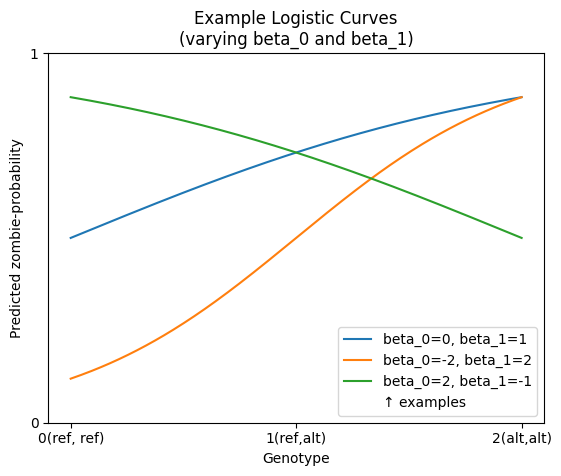

In [6]:
def logistic(x, beta_0, beta_1):
  return 1 / (1 + np.exp(-(beta_0 + beta_1 * x)))

x_vals = np.linspace(0,2, 300)

plt.figure()
# three example parameter sets
for b0,b1 in [(0,1), (-2,2), (2,-1)]:
  plt.plot(x_vals, logistic(x_vals, b0, b1), label=f"beta_0={b0}, beta_1={b1}")

plt.scatter([], [], label="↑ examples", alpha=0)  # placeholder for legend
plt.xlabel("Genotype")
plt.ylabel("Predicted zombie-probability")

plt.yticks([0,1], ["0", "1"])
plt.xticks([0,1,2], ["0(ref, ref)", "1(ref,alt)", "2(alt,alt)"])
plt.title("Example Logistic Curves\n(varying beta_0 and beta_1)")
plt.legend()
plt.show()

So for a given SNP, where we know the genotype and zombie status of each sample, our goal is to find the values of $\beta_0$ and $\beta_1$ for which the curve $p(x) = \dfrac{1}{1+e^{-(\beta_0+\beta_1 x)}}$ best fits the data. To put it in technical terms, we want to find the values of the parameters that [maximize the log-likelihood of the observed data.](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) If you don't know what that means, don't worry -- the Python [Statsmodels](https://www.statsmodels.org/stable/index.html) package will take care of it for us. (But if you *want* to understand how this is done, check out the [Statquest videos.](https://www.youtube.com/playlist?list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe)

Here's the code to perform the logistic regression for our example SNP:

In [7]:
# add constant column for intercept
X = sm.add_constant(snp)
model = sm.Logit(labels,X)
result = model.fit(disp=False)

print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Feb 2026   Pseudo R-squ.:                  0.4584
Time:                        23:56:26   Log-Likelihood:                -75.087
converged:                       True   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                 1.779e-29
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6200      0.400     -6.556      0.000      -3.403      -1.837
x1             2.7883      0.367      7.589      0.000       2.068       3.508


There's a ot of information here, but the important part is the fit values for our $\beta_0$ and $\beta_1$ model parameters. We can grab those with this code:

In [8]:
fit_beta_0, fit_beta_1 = result.params

print(f"Fit beta_0: {round(fit_beta_0, 3)}")
print(f"Fit beta_1: {round(fit_beta_1, 3)}")

Fit beta_0: -2.62
Fit beta_1: 2.788


**NOTE:** we'll refer to the estimated parameter values that we got by fitting the model as $\hat{\beta_0}$ and $\hat{\beta_1}$ (pronounched beta-1-hat and beta-2-hat -- or simply fit-beta-1 and fit-beta-2). There is a subtle but important difference between the parameter estimates $\hat{\beta_0}$ and $\hat{\beta_1}$ that we get by fitting the model to the data, and the true underlying values of $\beta_0$ and $\beta_1$, that we can never be sure about, but that we are trying to estimate.

Then we can use these fit values $\hat{\beta_0}$ and $\hat{\beta_1}$ to plot the fit logistic curve:

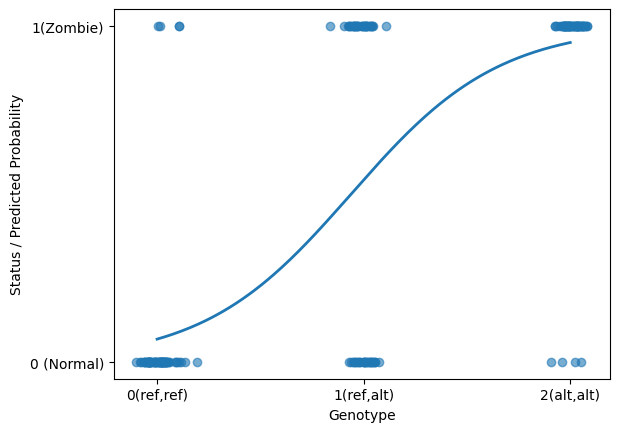

In [9]:
plt.figure()

# scatter raw data
plt.scatter(x_jitter, labels, alpha = 0.6)

# logistic curve using fitted params
x_plot = np.linspace(0,2,200)
y_plot = logistic(x_plot, fit_beta_0, fit_beta_1)
plt.plot(x_plot, y_plot, linewidth=2)

plt.yticks([0,1], ["Control", "Case"])
plt.xlabel("Genotype")
plt.ylabel("Status / Predicted Probability")
plt.yticks([0,1], ["0 (Normal)", "1(Zombie)"])
plt.xticks([0,1,2], ["0(ref,ref)", "1(ref,alt)", "2(alt,alt)"])

plt.show()

We can also use these fit parameter value to calculate the predicted zombie-probabilites for each genotype:

In [10]:
prob_0 = logistic(0, fit_beta_0, fit_beta_1)
print(f"Zombie Probability, genotype 0(ref,ref)={round(prob_0,3)}")
print()

prob_1 = logistic(1,fit_beta_0, fit_beta_1)
print(f"Zombie Probability, genotype 1(ref,alt) = {round(prob_1,3)}")
print()

prob_2 = logistic(2, fit_beta_0, fit_beta_1)
print(f"Zombie Probability, genotype 2(alt,alt) = {round(prob_2,3)}")
print()

Zombie Probability, genotype 0(ref,ref)=0.068

Zombie Probability, genotype 1(ref,alt) = 0.542

Zombie Probability, genotype 2(alt,alt) = 0.951



Lastly we can grab the p-value of the $\beta_1$ parameter(the parameter that multiplies the genotype):

In [11]:
p_value = result.pvalues[1]
print(p_value)

3.2354440875886555e-14


Again, all of this extra information is good to know, but for the GWAS we're about to do, the p-value for the $\beta_1$ parameter is the important part.

**p-value (technical definition for this model):** the probability of observing a fitted value $(\hat\beta_1)$ at least as extreme as the one we obtained (measured in standard‑error units from 0), due to random sampling, if the true underlying parameter value is $\beta_1 = 0$ (meaning no relationship between SNP genotype and zombie phenotype).

**p-value (sloppy but easy-to-understand defintion, fine for our purposes):** probability of seeing a skew in the data between SNP-genotype and zombie-phenotype by coincidence if there were no true underlying relationship.

One last thing -- for this project, we're doing a simplified analysis where we only know the genotype and zombie-status for each sample, and have no other information about the person. But in a real-life GWAS we'd probably have more information, like the person's age, sex, ethnicity, health background, etc, that might also be relevant. A nice thing about the logistic regression model is that we can easily add in more predictor variables to test besides just the genotype. So let's say that in addition to having the genotype $x$, we also have two more predictor variables $y$ and $z$. Maybe $y \in (0,1)$ tells us whether the person was a smoker or not, with $y=0$ corresponding to a non-smoker and $y=1$ corresponding to a smoker. And maybe $z$ is the person's age.

Then the equation for the probability curve would look like this, with two new parameters $\beta_2$ and $\beta_3$, to account for the effects of $y$ and $z$ on the zombie-probability:

$$
{\huge p(x) = \dfrac{1}{1+e^{-(\beta_0+\beta_1 x +\beta_2 y +\beta_3 z)}}}
$$

Here's how we would run the logistic regression in Python, including these covariates:

In [12]:
# binary smoker status: ~30% smokers
smoker_status = np.random.binomial(1, 0.3,size=len(labels))

# age in years: mean 50, sd 10
age = np.random.normal(loc=50,scale=10, size=N).astype(int)

X = np.column_stack((snp, smoker_status, age))
X = sm.add_constant(X)

# columns: constants, snp, smoker, age
model = sm.Logit(labels, X)
result = model.fit(disp=False)

print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Fri, 27 Feb 2026   Pseudo R-squ.:                  0.4643
Time:                        23:56:35   Log-Likelihood:                -74.270
converged:                       True   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                 1.022e-27
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4155      1.167     -2.926      0.003      -5.703      -1.128
x1             2.7664      0.369      7.498      0.000       2.043       3.490
x2            -0.4582      0.474     -0.967      0.3

**NOTE:** Adding these covariates actually changes the meaning and interpretation of the $\beta_0$ constant parameter. When we were including only genotypes, it told us the baseline zombie-probability for samples with genotype $x=0$. Now, it tells us the baseline probability for samples with genotype $x=0$, smoker status $y=0$, and age $z=0$. The age $z=0$ part doesn't make any sense, so there is no longer a meaningful interpretation of the value of $\beta_0$. (Although if we wanted to, we could center $z$ around the average age, so that $\beta_0$ would tell us the baseline zombie-probability for non-smokers of the average age with genotype $x=0$.)

Anyway, for the educational purposes of this project, we're going to keep things simple and assume that we have only the zombie-status and genotypes for each sample, and don't have any additional covariate information.

### Step 2: Reading in the Data

In our mock dataset, there is a row for each SNP. For each row, the first three columns contain the information about the SNP: snp_id  (chromosome number and position), the reference allele/nucleotide, and the alternate allele/nucleotide.

Then there are 200 columns, correspondinf to the 200 samples labeled in the heading row. The first 100 are the control samples(those that didn't turned into zombies). The next 100 are the "case" samples those that did turned into zombies. For each SNP, the column for each samples contains 0, 1 or 2.  This tells us how many copies of the alternate allele the person had. All SNPs in this dataset have only one possible alternate allele, so for our purposes a 0 means they were homozygous for the reference allele, 1 means they were heterozygous (one of each), and 2 means homozygous for the alternate allele.

**NOTE:** in real datasets, it is not always safe to assume that a 0 means they had 2 copies of the reference allele (or that a 1 means one of each), because the same SNP position could have more than one alternate allele. But for the educational purposes of this project we'll assume that each chromosome position has only one possible alternate allele, so a 0 in the spreadsheet implies 2 copies of the reference allele, and 1 means one of each.

To start, let's read in all this data. We'll store the first four columns in a list called `snp_info`, and the rest in a list of lists called `data`.

In [13]:
snp_info  = []
data = []
with open("data/example_data.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  
  for row in reader:
    snp_info.append(row[0:3])
    data.append(row[3:])

THe first row was the column headings, so we'll remove that from both `snp_info` and `data` and store it separately.

In [14]:
snp_header = snp_info[0]
snp_info = snp_info[1:]

samples = data[0]
data = data[1:]

Next, we'll cast all these lists to NumPy arrays to make them easier to work with. And remember, we need to cast the elements in `data` to ints since they were read as strings by default.

In [15]:
snp_info = np.array(snp_info)
data = np.array(data).astype(int)

snp_header = np.array(snp_header)
samples = np.array(samples)


In [16]:
print(snp_info.shape)
print(data.shape)
print()
print(snp_header.shape)
print(samples.shape)

(48752, 3)
(48752, 200)

(3,)
(200,)


In [17]:
print("snp_header:")
print(snp_header)
print()

print("samples:")
print(samples[0:3])
print()

print("snp_info:")
print(snp_info[0:5])
print()

print("data:")
print(data[0:5, 0:3])
print()

snp_header:
['snp_id' 'ref' 'alt']

samples:
['normal_1' 'normal_2' 'normal_3']

snp_info:
[['chr1:944564' 'T' 'C']
 ['chr1:950243' 'A' 'C']
 ['chr1:959842' 'C' 'T']
 ['chr1:990417' 'T' 'C']
 ['chr1:1297065' 'C' 'T']]

data:
[[2 2 1]
 [0 1 1]
 [1 2 1]
 [0 2 2]
 [2 1 0]]



Next, we want to make an array with case/control labels for each sample. We can do this with some pretty basic string manipulation.

In [18]:
labels = []

for i in range(len(samples)):
  tmp = samples[i].split("_")
  labels.append(tmp[0])
    
labels = np.array(labels)

In [19]:
print(labels[0:5])

print(np.unique(labels))

['normal' 'normal' 'normal' 'normal' 'normal']
['normal' 'zombie']


### Step 3: Minor Allele Frequency Filter

Before doing the GWAS analysis, we'll filter down our list of SNPs a bit and keep the ones that have suffiecient representation of both the reference and alternate alleles, since these are the the ones that will be interesting to look at.

To do this, we'll calculate the minor allele frequency(MAF) for each SNP. Note: "minor allele" here just means the less common allele of the two, and can be either the reference or the alternate allele. Before we do the filter, let's practice calculating this number for just the first SNP.

In [20]:
first_snp = data[0,:]
print(first_snp)

[2 2 1 1 2 1 2 0 1 1 2 0 2 1 0 0 0 0 1 0 1 1 2 2 1 1 1 1 1 0 2 2 0 0 2 2 2
 1 2 2 2 1 0 1 2 1 2 2 2 1 1 2 1 1 0 1 1 2 0 1 1 2 1 2 2 0 2 2 1 0 0 1 1 2
 2 2 2 1 1 2 2 1 1 1 2 1 1 2 2 2 1 2 1 0 1 2 2 2 2 1 1 2 1 0 2 0 1 0 2 1 2
 2 1 2 1 2 1 1 2 2 0 1 1 2 1 0 1 1 2 2 1 0 2 1 1 2 2 0 2 2 1 2 2 1 2 2 0 1
 2 0 1 0 2 2 0 1 1 2 0 1 2 2 2 1 2 2 2 2 0 1 2 1 1 1 1 0 0 2 0 1 1 0 1 2 2
 1 2 1 1 2 1 2 0 1 1 0 2 1 1 0]


To get the MAF, we'll need the total counts of all alleles for the SNP. Since every sample has 2 alleles, we can get this by multiplying the number of samples by 2. This should give us 400.

In [21]:
total_alleles_per_snp = len(samples) * 2
print(total_alleles_per_snp)

400


Next, we need the reference allele count for the first SNP. Remember, if a sample is labeled with `0`, that means it has 2 copies of the reference allele ("homozygous" for the reference allele). If it's labeled with `1`, that means it has 1 copy of the reference allele ("heterozygous"). So we can get the reference allele count for the first SNP like this:

In [22]:
ref_allele_count = 2 * np.sum(first_snp == 0) + np.sum(first_snp == 1)
# purposely writing this in a mathematically inefficient way to communicate the point
# could just be total_alleles_per_snp - np.sum(first_snp)
print(ref_allele_count)

155


In [23]:
alt_allele_count = 2 * np.sum(first_snp == 2) + np.sum(first_snp == 1)
# purposfully writing this in a mathematically inefficient way to communicate the point
# could be just total_alleles_per_snp - ref_allele_count

print(alt_allele_count)

245


Now we'll computr the minor allele frquency. Remember, "minor allele" just means the less common one, and it canbe either the reference allele or alternate allele. So, we'll use `min(ref_allele_count,alt_allele_count)` to select the less common of the two, and then divide by `total_alleles_per_snp` to get the frequency.

In [24]:
maf = min(ref_allele_count, alt_allele_count) / total_alleles_per_snp
print(maf)

0.3875


Ok, now that we have our minor allele frequency, we can decide to keep or filter out the SNP, based on whether or not it passes a threshold that we set. Common thresholds are `0.01` or `0.05`, so using either one of those we'd end up keeping this SNP.

Now we can go through and do this calculation for every SNP, and keep a record of the ones that pass the threshold, we'll set to `0.05`.

In [25]:
maf_threshold = 0.05
total_alleles_per_snp = len(samples) * 2
to_keep = []
for i in range(data.shape[0]):
  # again writing these in a mathematically inefficient way to hopefully make it clear what we're counting
  ref_allele_count = 2 * np.sum(data[i,:] == 0) + np.sum(data[i,:] == 1)
  alt_allele_count = 2 * np.sum(data[i,:] == 2) + np.sum(data[i,:] == 1)

  maf = min(ref_allele_count, alt_allele_count) / total_alleles_per_snp
  if maf >= maf_threshold:
    to_keep.append(True)
  else:
    to_keep.append(False)


Now we apply the filter:

In [27]:
to_keep = np.array(to_keep)

filtered_snp_info = snp_info[to_keep,:]
filtered_data = data[to_keep,:]

print("Shape Checks:")
print(filtered_snp_info.shape)
print(filtered_data.shape)
print()
print(f"Percent Kept: {filtered_data.shape[0]/data.shape[0] * 100}")

Shape Checks:
(43908, 3)
(43908, 200)

Percent Kept: 90.06399737446668


### Step 4: GWAS Analysis

Now We'll check each SNP to see if its distribution differs significantly between the zombiew/normal phenotypes. To do this, we'll use the logistic regression test that we previously reviewed, from the `statsmodels.api`.

To start, we're going to convert our `labels` array to a binary array, where 1 means "zombie" and 0 means "normal". This will some of the following steps easier. Here's how we do that:

In [28]:
encoded_labels = np.where(labels == "zombie", 1, 0)
print(encoded_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Now let's try out the logistic regression test on just the first SNP, to make sure it's working properly. We'll start by getting all the genotypes for that SNP like this:

In [30]:
first_snp = filtered_data[0,:]

Remember, this  tells us whether each sample was homozygous for the reference nucleotide(0), heterizygous(1), or homozygous for the variant nucleotide(2), for all 200 of samples. Let's take a look:

In [31]:
print(first_snp)

[2 2 1 1 2 1 2 0 1 1 2 0 2 1 0 0 0 0 1 0 1 1 2 2 1 1 1 1 1 0 2 2 0 0 2 2 2
 1 2 2 2 1 0 1 2 1 2 2 2 1 1 2 1 1 0 1 1 2 0 1 1 2 1 2 2 0 2 2 1 0 0 1 1 2
 2 2 2 1 1 2 2 1 1 1 2 1 1 2 2 2 1 2 1 0 1 2 2 2 2 1 1 2 1 0 2 0 1 0 2 1 2
 2 1 2 1 2 1 1 2 2 0 1 1 2 1 0 1 1 2 2 1 0 2 1 1 2 2 0 2 2 1 2 2 1 2 2 0 1
 2 0 1 0 2 2 0 1 1 2 0 1 2 2 2 1 2 2 2 2 0 1 2 1 1 1 1 0 0 2 0 1 1 0 1 2 2
 1 2 1 1 2 1 2 0 1 1 0 2 1 1 0]


In [32]:
X = sm.add_constant(first_snp)
result = sm.Logit(encoded_labels, X).fit(disp=False)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Sat, 28 Feb 2026   Pseudo R-squ.:               0.0008285
Time:                        01:03:11   Log-Likelihood:                -138.51
converged:                       True   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                    0.6317
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1126      0.274      0.410      0.682      -0.425       0.650
x1            -0.0919      0.192     -0.479      0.632      -0.468       0.284


The test result gives a lot of information, but the only thing we need is the p_value.Here's how we can grab it:

In [33]:
p_value = result.pvalues[1]
print(p_value)

0.6319294941622743


Remember, the p-value tells us the probability of seeing a difference between zombie/normal genotypes at least as extreme as the one we're seeing, by coincidence alone, if the null hypothesis were true (that is, if there were no underlying difference between the zombie/normal genotype distributions). The p-value for this first SNP is pretty high, meaning that the difference between the zombie/normal genotypes could easily be seen by coincidence.

Ok, so far so good! Now we just need to do this for all the SNPs and record the p-values.

In [34]:
p_values = []
for i in range(filtered_data.shape[0]):
  snp_genotypes = filtered_data[i,:]

  X = sm.add_constant(snp_genotypes.astype(float))

  result = sm.Logit(encoded_labels,X).fit(disp=False)
  p_value = result.pvalues[1]
  p_values.append(p_value)

/home/mim/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Alright, slight problem-- it looks like at least one of the SNPs, the logistic regression model didn't properly converge on an answer, meaning the test results(including the p_value) are unreliable. But this is easily fixable, we'll just add an if/else statement to only save p_value if the model converges properly, and save a p_value of 1 (the least significant p_value) if it doesn't converge properly.

In [35]:
p_values = []

for i in range(filtered_data.shape[0]):
  snp_genotypes = filtered_data[i,:]
  
  X = sm.add_constant(snp_genotypes.astype(float))
  result = sm.Logit(encoded_labels,X).fit(disp=False)

  if result.mle_retvals["converged"]:
    p_value = result.pvalues[1]
    p_values.append(p_value)
  else:
    p_value = 1.0
    p_values.append(p_value)

/home/mim/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Now we'll convert our `p_values` list to a NumPy array, to make it easier to work with.

In [36]:
p_values = np.array(p_values)

In [37]:
print(np.sum(np.isnan(p_values)))
print(p_values[0:5])

0
[0.63192949 1.         0.18372127 0.12938926 0.11749343]


Next we'll do a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction), multiplying each p-value by the number of tests we did. Here's a [great comic](https://xkcd.com/882/) explaining why this is necessary.

In [38]:
p_values_bonf = p_values * len(p_values)

(**NOTE:** in practice, people typically use another multiple-test correction called the [Benjamini-Hochberg correction](https://www.youtube.com/watch?v=K8LQSvtjcEo), which is more lenient. But for educational purposes, we'll use the Bonferroni correction, since it's easier to understand on an inuitive level.)

Now we can check to see if any SNPs came up statistically significant, after the Bonferroni correction.

In [39]:
print(filtered_snp_info[p_values_bonf <= 0.05, ])

[['chr1:221240797' 'G' 'A']
 ['chr2:25491016' 'T' 'C']
 ['chr2:27677691' 'G' 'A']
 ['chr2:217890643' 'A' 'G']
 ['chr2:239567125' 'T' 'C']
 ['chr3:52739520' 'T' 'C']
 ['chr5:42582527' 'C' 'T']
 ['chr5:102282317' 'C' 'T']
 ['chr5:179729519' 'A' 'G']
 ['chr6:28169158' 'T' 'A']
 ['chr6:140688409' 'A' 'G']
 ['chr7:92657985' 'A' 'G']
 ['chr7:135262533' 'T' 'C']
 ['chr9:119176250' 'T' 'C']
 ['chr10:121124501' 'A' 'G']
 ['chr11:1890990' 'G' 'A']
 ['chr11:85436868' 'G' 'C']
 ['chr11:119054488' 'C' 'T']
 ['chr12:66359752' 'C' 'A']
 ['chr14:70469255' 'A' 'C']
 ['chr15:45526391' 'T' 'G']
 ['chr15:66051299' 'C' 'T']
 ['chr15:85171495' 'A' 'C']
 ['chr15:86159953' 'G' 'A']
 ['chr15:90113932' 'C' 'T']
 ['chr18:41427543' 'G' 'T']
 ['chr20:48597659' 'A' 'G']]


If we want to check out any of these SNPs, a good web application for that is the [UCSC Genome Browser](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr7%3A155799529%2D155812871&hgsid=3744857711_FIRv4Ol0ASZX7D9ZipZ4aAqVcpO5).

### Step 5: Manhattan Plot

Now we'll make a Manhattan plot to visualize these results. First, we'll parse the `snp_ids` to separate the chromosome numbers and positions, and cast them to ints.